<a href="https://colab.research.google.com/github/Priyo-prog/Deep-Learning-with-Tensorflow/blob/main/Transfer%20Learning%20with%20Tensorflow/transfer_learning_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning with Tensorflow**

What is Transfer Learning ?

Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.

**Pre-Training**
When we train the network on a large dataset(for example: ImageNet) , we train all the parameters of the neural network and therefore the model is learned. It may take hours on your GPU.

**Fine Tuning**
We can give the new dataset to fine tune the pre-trained CNN. Consider that the new dataset is almost similar to the orginal dataset used for pre-training. Since the new dataset is similar, the same weights can be used for extracting the features from the new dataset.
If the new dataset is very small, it’s better to train only the final layers of the network to avoid overfitting, keeping all other layers fixed. So remove the final layers of the pre-trained network. Add new layers . Retrain only the new layers.
If the new dataset is very much large, retrain the whole network with initial weights from the pretrained model. 

# **This part 1 Feature Extraction**

## Downloading and becoming one with data

In [1]:
# Get data (10% of 10 food classes from Fodd101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-01-12 04:23:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 64.233.191.128, 173.194.74.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   147MB/s    in 1.1s    

2022-01-12 04:23:54 (147 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")


There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza

## Creating data loaders(preparing the data)

We will use ImagedataGenerator class to load in our images in batches

In [3]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Hyperparameters are put in caps in deep learning
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=32,
                                                          class_mode="categorical")

print("Testing images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE ,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while our model trains)

Callbaks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits)
with EarlyStopping callbacks 
[Tensorflow Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks)

In [4]:
# Build a helper fuction for Tensorboard Callbacks

import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard logfiles to: {log_dir}")
  return tensorboard_callback

## Creating models using Tensorflow Hub

In the past we have used Tensorflow to create our models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from Tensorflow Hub.

We can access pretrained models on: https://tfhub.dev/ 

Browsing the Tensorflow Hub page and sorting for image classification, we found the following feature vector model link


link : [Feature Vector](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1)

In [5]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [6]:
# Import dependenceies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [8]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a Tensorflow Hub URL and creates a Keras Sequential model with it.

  Args:
   model_url(str): A Tensorflow Hub feature extraction URL.
   num_classes(int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns: 
   An uncompiled Keras Sequential model with model_url as feature extractor 
   layer and Dense output layer with num_classes output neurons.  
  """
  # Download the pretrained model and save it as Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False, # freeze the already learned patterns
                                            name="feature_extraction_layer",
                                            input_shape=IMAGE_SHAPE+(3,)) 
  
  # Create our own model
  model = tf.keras.Sequential([
     feature_extractor_layer,
     layers.Dense(num_classes, activation="softmax", name="output_layer")                           
  ])

  return model

## Creating and testing ResNet Tensorflow Hub Feature Extraction model 

In [9]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
# Compile our ResNet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [12]:
# Let's fit our ResNet model to our data(10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                         experiment_name="resnet50V2")])

Saving Tensorboard logfiles to: tensorflow_hub/resnet50V2/20220112-042412
Epoch 1/5
24/24 [==============================] - 44s 1s/step - loss: 1.9889 - accuracy: 0.3560 - val_loss: 1.1991 - val_accuracy: 0.6104
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 0.9346 - accuracy: 0.7387 - val_loss: 0.8566 - val_accuracy: 0.7180
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.6364 - accuracy: 0.8173 - val_loss: 0.7583 - val_accuracy: 0.7568
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.4991 - accuracy: 0.8800 - val_loss: 0.7176 - val_accuracy: 0.7724
Epoch 5/5
24/24 [==============================] - 26s 1s/step - loss: 0.3946 - accuracy: 0.9147 - val_loss: 0.6901 - val_accuracy: 0.7784


Our Transfer learning feature extractor model out performed all of the previous models we built by scratch and in quicker training time AND with 10% of the training data

## Create a function to plot our loss curves

In [13]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrices.

  Args:
   history: Tensorflow History object

  Returns:
   Plots of training/ validation loss and accuracy metrics. 
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

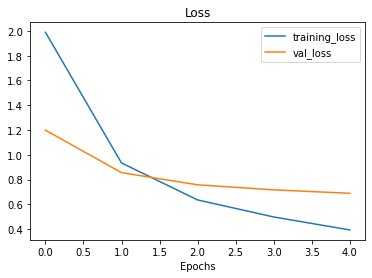

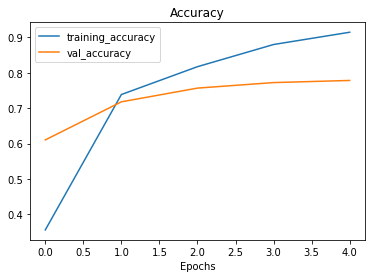

In [14]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 Tensorflow Hub Feature Extraction model 

In [16]:
## Create EfficientnetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit EfficientNet model to 10 percent data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving Tensorboard logfiles to: tensorflow_hub/efficientnetb0/20220112-044321
Epoch 1/5
24/24 [==============================] - 43s 1s/step - loss: 1.8529 - accuracy: 0.4000 - val_loss: 1.2854 - val_accuracy: 0.7456
Epoch 2/5
24/24 [==============================] - 22s 941ms/step - loss: 1.0480 - accuracy: 0.7840 - val_loss: 0.8528 - val_accuracy: 0.8296
Epoch 3/5
24/24 [==============================] - 21s 919ms/step - loss: 0.7430 - accuracy: 0.8360 - val_loss: 0.6875 - val_accuracy: 0.8500
Epoch 4/5
24/24 [==============================] - 22s 926ms/step - loss: 0.5995 - accuracy: 0.8720 - val_loss: 0.6025 - val_accuracy: 0.8600
Epoch 5/5
24/24 [==============================] - 21s 909ms/step - loss: 0.5052 - accuracy: 0.8973 - val_loss: 0.5503 - val_accuracy: 0.8700


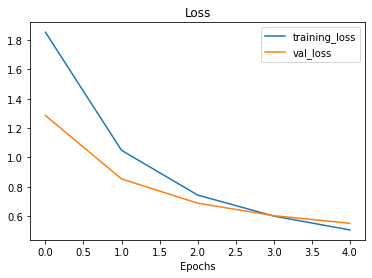

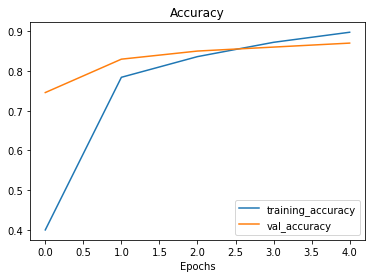

In [17]:
plot_loss_curves(efficientnet_history)

## Different types of Transfer Learning

* **"As is" transfer learning** - using and existing model with no changes what so ever(e.g uisng ImageNet model on 1000 ImageNet classes)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g 1000 classes -> 10 classes of food)
* **"Fine Tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers). 